#### PPGIA - Unifor - Prof. Daniel - Processamento e analise de imagens digitais - TrabalhoFinal02 - Filtros do Instagram

#### Importação de Bibliotecas

In [61]:
import numpy as np
import pandas as pd
import cv2 
print(cv2.__version__)
#Path Google Colab para CV2
from google.colab.patches import cv2_imshow
from google.colab import files
import dlib
from skimage import io
from PIL import Image 
%matplotlib inline
#A linha acima é necessária para mostrar gráficos Matplotlib dentro de um Notebook Jupyter
from matplotlib import pyplot as plt
#import matplotlib.pylab as plt
import sys
import ipywidgets as widgets
from IPython.display import display
import scipy
from scipy import interpolate
#import face_recognition
import pickle
import gzip
import time
from math import asin, pi
from math import hypot
#from .utils.geometry import Point, dot

4.1.2


In [23]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.core import Dense
from tensorflow.keras.optimizers import SGD
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras

#### Upload do arquivo

In [24]:
#Upload do arquivo de imagens que será utilizado no exemplo (lena.png)
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving eu.jpg to eu.jpg
User uploaded file "eu.jpg" with length 25626 bytes


#### Funções

In [90]:
#Funcao para Exibir Imagens com matplotlib e cv2
def exibir_imgplt(tmpimg):
  #Importar a Imagem
  image = cv2.imread(tmpimg, cv2.IMREAD_UNCHANGED)
  #Aplicando a máscara de onde os bits transparentes estão
  #trans_mask = image[:,:,3] == 0
  #substitua as áreas de transparência por branco e não transparente
  #image[trans_mask] = [255, 255, 255, 255]
  image = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  #Mostra a imagem com matplotlib
  plt.figure(figsize = (100,10))
  plt.imshow(image)
  plt.show()
  return

In [91]:
#Botão para exibir a imagem que foi realizado Upload
button = widgets.Button(description="Exibir Img CV2PLT")
output = widgets.Output()

def on_button_clicked_exibir_imagem(b):
  with output:
    img = cv2.cvtColor(cv2.imread(next(iter(uploaded))), cv2.COLOR_BGR2RGB)
    print("Exibindo Imagens:")
    print("Resolução: ", img.shape[0: 2])
    #print(img) # Imprimindo a imagem como NumpyArray
    exibir_imgplt(next(iter(uploaded)))
button.on_click(on_button_clicked_exibir_imagem)
display(button, output)

Button(description='Exibir Img CV2PLT', style=ButtonStyle())

Output()

In [98]:
# Definição dos pontos referentes a cada parte do rosto
NOSE_POINTS = list(range(27, 36))  
RIGHT_EYE_POINTS = list(range(36, 42))  
LEFT_EYE_POINTS = list(range(42, 48))  
MOUTH_INNER_POINTS = list(range(61, 68))  
EYEBROWS_POINTS = list(range(17, 28))  
LEFT_EYE_POINT = 36
RIGHT_EYE_POINT = 45
CENTER_MOUTH_POINT = 63
TOP_NOSE_POINT = 28
UNDER_NOSE_POINT = 32
NOSE_POINT = 30
TOP_TONGUE_POINT = 62
BOT_TONGUE_POINT = 66
LEFT_EAR_POINT = 17
RIGHT_EAR_POINT = 26

#Funcao para Exibir Imagens com os marcos faciais
def put_debug(img, landmarks, x, y, w, h):
    """ Filtro de debug, imprime alguns pontos de landmarks, retangulo da face e retas de inclinacao da face
        img: imagem em que sera desenhado o filtro
        landmarks: array de pontos da face
        (x, y): ponto mais a esquerda em cima do retangulo da face
        w: largura do retanculo da face
        h: altura do retangulo da face
    """
    # desenha retangulo da face
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
    # pontos da face a serem mostrados (olho direito, olho esquerdo, naris e boca)
    landmarks_display = landmarks[RIGHT_EYE_POINTS + LEFT_EYE_POINTS + NOSE_POINTS + MOUTH_INNER_POINTS]

    # imprime os pontos da face
    for idx, point in enumerate(landmarks_display):
        pos = (point[0, 0], point[0, 1])
        cv2.circle(img, pos, 2, color=(0, 255, 255), thickness=-1)
    
    #Mostra a imagem com matplotlib
    plt.figure(figsize = (100,10))
    plt.imshow(img)
    plt.show()

def exibir_marco(tmpimg):
  #Importar a Imagem
  image = cv2.imread(tmpimg, cv2.IMREAD_UNCHANGED)
  #Aplicando a máscara de onde os bits transparentes estão
  #trans_mask = image[:,:,3] == 0
  #substitua as áreas de transparência por branco e não transparente
  #image[trans_mask] = [255, 255, 255, 255]
  image = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  from google.colab import drive
  drive.mount('/content/drive')
  path = r"/content/drive/MyDrive/Daniel Moraes/Documentos/Cursos/Unifor/Topicos CG/img/"
  face_cascade = cv2.CascadeClassifier(path+'lbpcascade_frontalface.xml')
  predictor = dlib.shape_predictor(path+'shape_predictor_68_face_landmarks.dat')

  faces = face_cascade.detectMultiScale(image, scaleFactor=1.1, minNeighbors=5)

  for (x, y, w, h) in faces:
      dlib_rect = dlib.rectangle(int(x), int(y), int(x + w), int(y + h))
      landmarks = np.matrix([[p.x, p.y] for p in predictor(ori_img, dlib_rect).parts()])
      put_debug(image, landmarks, x, y, w, h)

  return

#Botão para exibir a imagem que foi realizado Upload
button2 = widgets.Button(description="Exibir Marco")
output2 = widgets.Output()

def on_button_clicked_exibir_marco(b):
  with output2:
    img = cv2.cvtColor(cv2.imread(next(iter(uploaded))), cv2.COLOR_BGR2RGB)
    print("Exibindo Imagens:")
    print("Resolução: ", img.shape[0: 2])
    #print(img) # Imprimindo a imagem como NumpyArray
    exibir_marco(next(iter(uploaded)))
button2.on_click(on_button_clicked_exibir_marco)
display(button2, output2)

Button(description='Exibir Marco', style=ButtonStyle())

Output()

In [103]:
#Funcao para Anonimizar Rostos
def filtro_pig(tmpimg):

  #Nariz
  nose_image = cv2.imread("/content/pig_nose.png")

  #Importar a Imagem
  imagem = cv2.imread(tmpimg)
  imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)
  #Detectar Face
  detector = dlib.get_frontal_face_detector()
  facesDetectadas = detector(imagem, 3)
  print(facesDetectadas)
  print("Faces detectadas: ", len(facesDetectadas))
  for face in facesDetectadas:
    
    landmarks = predictor(imagem, face)

    # Nose coordinates
    top_nose = (landmarks.part(29).x, landmarks.part(29).y)
    center_nose = (landmarks.part(30).x, landmarks.part(30).y)
    left_nose = (landmarks.part(31).x, landmarks.part(31).y)
    right_nose = (landmarks.part(35).x, landmarks.part(35).y)

    nose_width = int(hypot(left_nose[0] - right_nose[0], left_nose[1] - right_nose[1]) * 1.7)
    nose_height = int(nose_width * 0.77)

    # Posição do novo nariz
    top_left = (int(center_nose[0] - nose_width / 2), int(center_nose[1] - nose_height / 2))
    bottom_right = (int(center_nose[0] + nose_width / 2), int(center_nose[1] + nose_height / 2))


    # Adicionar um novo nariz
    nose_pig = cv2.resize(nose_image, (nose_width, nose_height))
    nose_pig_gray = cv2.cvtColor(nose_pig, cv2.COLOR_BGR2GRAY)
    _, nose_mask = cv2.threshold(nose_pig_gray, 25, 255, cv2.THRESH_BINARY_INV)

    nose_area = imagem[top_left[1]: top_left[1] + nose_height,top_left[0]: top_left[0] + nose_width]
    nose_area_no_nose = cv2.bitwise_and(nose_area, nose_area, mask=nose_mask)
    final_nose = cv2.add(nose_area_no_nose, nose_pig)

    imagem[top_left[1]: top_left[1] + nose_height,top_left[0]: top_left[0] + nose_width] = final_nose

  #Mostra a imagem com matplotlib
  plt.figure(figsize = (100,10))
  plt.imshow(imagem)
  cv2.waitKey(0)
  cv2.destroyAllWindows()  
  plt.show()

  return

#Botão para exibir o filtro nariz
button3 = widgets.Button(description="Filtro Nariz")
output3 = widgets.Output()

def on_button_clicked_anonimizar_rosto(b):
  with output3:
    print("Filtro Nariz:")
    filtro_pig(next(iter(uploaded)))

button3.on_click(on_button_clicked_anonimizar_rosto)
display(button3, output3)

Button(description='Filtro Nariz', style=ButtonStyle())

Output()

In [104]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def tirar_foto(filename='foto.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capturar';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Redimensione a saída para caber no elemento de vídeo.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      //Aguarde até que seja clicado.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Salvo em foto.jpg


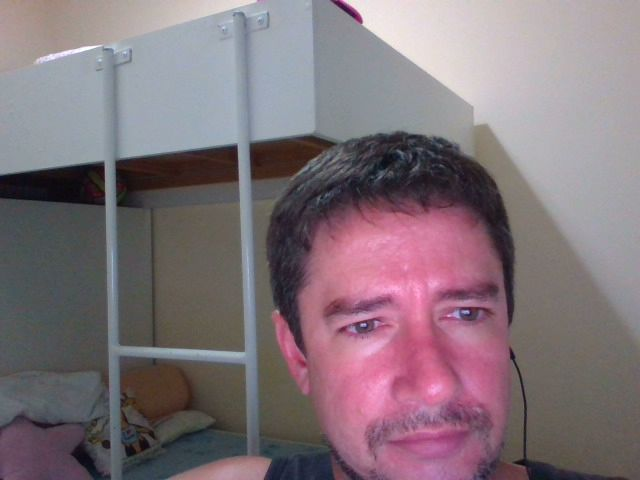

In [105]:
from IPython.display import Image
try:
  filename = tirar_foto()
  print('Salvo em {}'.format(filename))
  # Exibir a imgaem
  display(Image(filename))
except Exception as err:
  print(str(err))

In [108]:
#Botão para exibir o filtro nariz
button4 = widgets.Button(description="Filtro Nariz")
output4 = widgets.Output()

def on_button_clicked_anonimizar_rosto(b):
  with output4:
    print("Filtro Nariz:")
    filtro_pig('foto.jpg')

button4.on_click(on_button_clicked_anonimizar_rosto)
display(button4, output4)

Button(description='Filtro Nariz', style=ButtonStyle())

Output()